In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

from pycox.models import CoxPH
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import warnings
from sklearn.model_selection import KFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

np.random.seed(12)
_ = torch.manual_seed(12)

In [6]:
class TransformerSurvival(nn.Module):
    def __init__(self, in_features, d_model=32, out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection - 将输入特征投影到Transformer的维度
        self.input_proj = nn.Linear(in_features, d_model)
        
        # Positional encoding - 位置编码
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(d_model) if batch_norm else nn.Identity()
        
        # 直接输出层 - 从Transformer维度映射到输出维度
        self.output_layer = nn.Linear(d_model, out_features, bias=output_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)  # [batch_size, in_features] -> [batch_size, d_model]
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        # 添加序列维度并加上位置编码
        x = x.unsqueeze(1)  # [batch_size, d_model] -> [batch_size, 1, d_model]
        x = x + self.pos_encoding
        
        # Transformer处理
        x = self.transformer(x)  # [batch_size, 1, d_model]
        
        # 移除序列维度并直接输出
        x = x.squeeze(1)  # [batch_size, 1, d_model] -> [batch_size, d_model]
        
        # 直接映射到输出
        return self.output_layer(x)


# 简洁的创建函数
def create_transformer_network(in_features, d_model=32, out_features=1, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=2):
    """创建简化的Transformer生存网络（无中间输出层）"""
    return TransformerSurvival(
        in_features=in_features,
        d_model=d_model,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )

In [7]:
from pycox.datasets import metabric
import pandas as pd
# 读取数据
df = metabric.read_df()
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
print(df.head())
print(df.shape)
print("删失率:", 1 - df["event"].mean())

         x0        x1         x2        x3   x4   x5   x6   x7         x8  \
0  5.603834  7.811392  10.797988  5.967607  1.0  1.0  0.0  1.0  56.840000   
1  5.284882  9.581043  10.204620  5.664970  1.0  0.0  0.0  1.0  85.940002   
2  5.920251  6.776564  12.431715  5.873857  0.0  1.0  0.0  1.0  48.439999   
3  6.654017  5.341846   8.646379  5.655888  0.0  0.0  0.0  0.0  66.910004   
4  5.456747  5.339741  10.555724  6.008429  1.0  0.0  0.0  1.0  67.849998   

     duration  event  
0   99.333336      0  
1   95.733330      1  
2  140.233337      0  
3  239.300003      0  
4   56.933334      1  
(1904, 11)
删失率: 0.4206932773109243


In [8]:
# 设置重复次数和折数
n_repeats = 20
n_folds = 5
total_runs = n_repeats * n_folds
batch_size = 256
epochs = 200

# 初始化结果存储
cindex = np.zeros((total_runs, 5))
ibs = np.zeros((total_runs, 5))

print(f"开始进行 {n_repeats} 次重复的 {n_folds} 折交叉验证，总共 {total_runs} 次运行...")
j=-1
for repeat in range(n_repeats):
    if repeat%10==0:
        print(f"第 {repeat + 1}/{n_repeats} 次重复...")
    
    # 每次重复时随机打乱数据
    df_shuffled = df.sample(frac=1, random_state=repeat).reset_index(drop=True)
    
    # 初始化KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=repeat)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df_shuffled)):
        # 划分训练集和测试集
        j=j+1
        df_train = df_shuffled.iloc[train_idx]
        df_test = df_shuffled.iloc[test_idx]
        
        # 从训练集中划分验证集
        df_val = df_train.sample(frac=0.2, random_state=repeat)
        df_train = df_train.drop(df_val.index)
        
        # 数据预处理
        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')
        
        # 数据预处理 - 传统机器学习模型（使用所有训练数据）
        x_train_ml = x_mapper.fit_transform(df_train).astype('float32')
        x_test_ml = x_mapper.transform(df_test).astype('float32')
        
        get_target = lambda df: (df['duration'].values, df['event'].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        
        ## 专门为DeepHit设计，转换成离散时间
        num_durations = 10
        labtrans = DeepHitSingle.label_transform(num_durations)
        y_train2 = labtrans.fit_transform(*get_target(df_train))
        y_val2 = labtrans.transform(*get_target(df_val))
        train2 = (x_train, y_train2)
        val2 = (x_val, y_val2)
        
        val = (x_val, y_val)
        # 准备生存分析格式（用于Cox和RSF）
        def prepare_survival_data(df):
            return np.array([(row['event'], row['duration']) for _, row in df.iterrows()], 
                          dtype=[('event', '?'), ('time', '<f8')])
        
        y_train_surv = prepare_survival_data(df_train)
        y_test_surv = prepare_survival_data(df_test)
        
        callbacks1 = [tt.callbacks.EarlyStopping()]
        callbacks2 = [tt.callbacks.EarlyStopping()]
        callbacks3 = [tt.callbacks.EarlyStopping()]
        
        # 创建和训练模型
        net1 = create_transformer_network(
            in_features= x_train.shape[1],
            d_model=64,
            out_features=1,
            nhead=2,
            num_layers=1,
            dropout=0.1,
            batch_norm=True,
            output_bias=False
        )
        model1 = CoxPH(net1, tt.optim.Adam)
        model1.optimizer.set_lr(0.01)

        ## model 2
        net2 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = 1, batch_norm = True,
                                      dropout = 0.1,  output_bias = False)
        model2 = CoxPH(net2, tt.optim.Adam)
        model2.optimizer.set_lr(0.01)
        
        ## model 3
        net3 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = labtrans.out_features, 
                                      batch_norm = True, dropout = 0.1)
        model3 = DeepHitSingle(net3, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
        model3.optimizer.set_lr(0.01)
        
        # 模型4: Cox比例风险模型
        cox_model = CoxPHSurvivalAnalysis()
        
        # 模型5: 随机生存森林
        rsf_model = RandomSurvivalForest(
            n_estimators= 50,
            min_samples_split=10,
            min_samples_leaf=15,
            max_features="sqrt",
            n_jobs=-1,
            random_state=repeat
        )
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")
            log1 = model1.fit(x_train, y_train, batch_size, epochs, callbacks1, False,
                          val_data=val, val_batch_size=batch_size)
            log2 = model2.fit(x_train, y_train, batch_size, epochs, callbacks2, False,
                          val_data=val, val_batch_size=batch_size)
            log3 = model3.fit(x_train, y_train2, batch_size, epochs, callbacks3, False, 
                              val_data=val2, val_batch_size=batch_size)
            # 训练传统机器学习模型
            cox_model.fit(x_train_ml, y_train_surv)
            rsf_model.fit(x_train_ml, y_train_surv)
            
        # 计算基线风险并预测
        time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        ha1 = model1.compute_baseline_hazards()
        surv1 = model1.predict_surv_df(x_test)
        ha2 = model2.compute_baseline_hazards()
        surv2 = model2.predict_surv_df(x_test)
        
        ## DeepHit预测
        surv3 = model3.interpolate(num_durations).predict_surv_df(x_test)
        
        # Cox模型预测 - 插值到统一的时间网格
        cox_surv_fn = cox_model.predict_survival_function(x_test_ml)
        cox_max_time = min(fn.x[-1] for fn in cox_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid1 = np.linspace(durations_test.min(), cox_max_time, 100)
        cox_surv = np.zeros((len(x_test_ml), len(time_grid1)))
        for i, fn in enumerate(cox_surv_fn):
            cox_surv[i] = np.array([fn(t) for t in time_grid1])
        surv4 = pd.DataFrame(cox_surv.T, index=time_grid1)
        
        # RSF模型预测 - 插值到统一的时间网格
        rsf_surv_fn = rsf_model.predict_survival_function(x_test_ml)
        rsf_max_time = min(fn.x[-1] for fn in rsf_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid2 = np.linspace(durations_test.min(), rsf_max_time, 100)
        rsf_surv = np.zeros((len(x_test_ml), len(time_grid2)))
        for i, fn in enumerate(rsf_surv_fn):
            rsf_surv[i] = np.array([fn(t) for t in time_grid2])
        surv5 = pd.DataFrame(rsf_surv.T, index=time_grid2)

        # 评估模型
        ev1 = EvalSurv(surv1, durations_test, events_test, censor_surv='km')
        cindex[j,0] = ev1.concordance_td()
        ev2 = EvalSurv(surv2, durations_test, events_test, censor_surv='km')
        cindex[j,1] = ev2.concordance_td()
        ev3 = EvalSurv(surv3, durations_test, events_test, censor_surv='km')
        cindex[j,2] = ev3.concordance_td('antolini')
        ev4 = EvalSurv(surv4, durations_test, events_test, censor_surv='km')
        cindex[j,3] = ev4.concordance_td()
        ev5 = EvalSurv(surv5, durations_test, events_test, censor_surv='km')
        cindex[j,4] = ev5.concordance_td()
        
        ibs[j,0] = ev1.integrated_brier_score(time_grid)
        ibs[j,1] = ev2.integrated_brier_score(time_grid)
        ibs[j,2] = ev3.integrated_brier_score(time_grid)
        ibs[j,3] = ev4.integrated_brier_score(time_grid)
        ibs[j,4] = ev5.integrated_brier_score(time_grid)
        if j%50==0:
            print(f"  折 {fold + 1}/{n_folds} - C-index1: {cindex[j,0]:.4f}, C-index2: {cindex[j,1]:.4f},  C-index3: {cindex[j,2]:.4f}, C-index4: {cindex[j,3]:.4f}, C-index5: {cindex[j,4]:.4f}")
            print(f"  折 {fold + 1}/{n_folds} - IBS1: {ibs[j,0]:.4f}, IBS2: {ibs[j,1]:.4f},  IBS3: {ibs[j,2]:.4f},  IBS4: {ibs[j,3]:.4f},  IBS5: {ibs[j,4]:.4f}")

# 计算平均指标
mean_cindex = np.mean(cindex, axis=0)
mean_ibs = np.mean(ibs, axis=0)
std_cindex = np.std(cindex, axis=0)
std_ibs = np.std(ibs, axis=0)

print(f"\n最终结果 (基于 {total_runs} 次运行):")
print(f"模型1- Concordance Index: {mean_cindex[0]:.3f} ({std_cindex[0]:.3f})")
print(f"模型2- Concordance Index: {mean_cindex[1]:.3f} ({std_cindex[1]:.3f})")
print(f"模型3- Concordance Index: {mean_cindex[2]:.3f} ({std_cindex[2]:.3f})")
print(f"模型4- Concordance Index: {mean_cindex[3]:.3f} ({std_cindex[3]:.3f})")
print(f"模型5- Concordance Index: {mean_cindex[4]:.3f} ({std_cindex[4]:.3f})")
print(f"模型1- Integrated Brier Score: {mean_ibs[0]:.3f} ({std_ibs[0]:.3f})")
print(f"模型2- Integrated Brier Score: {mean_ibs[1]:.3f} ({std_ibs[1]:.3f})")
print(f"模型3- Integrated Brier Score: {mean_ibs[2]:.3f} ({std_ibs[2]:.3f})")
print(f"模型4- Integrated Brier Score: {mean_ibs[3]:.3f} ({std_ibs[3]:.3f})")
print(f"模型5- Integrated Brier Score: {mean_ibs[4]:.3f} ({std_ibs[4]:.3f})")

开始进行 20 次重复的 5 折交叉验证，总共 100 次运行...
第 1/20 次重复...
  折 1/5 - C-index1: 0.6651, C-index2: 0.6542,  C-index3: 0.6837, C-index4: 0.6630, C-index5: 0.6554
  折 1/5 - IBS1: 0.1668, IBS2: 0.1719,  IBS3: 0.1846,  IBS4: 0.1674,  IBS5: 0.1773
第 11/20 次重复...
  折 1/5 - C-index1: 0.6549, C-index2: 0.6474,  C-index3: 0.6424, C-index4: 0.6473, C-index5: 0.6371
  折 1/5 - IBS1: 0.1562, IBS2: 0.1618,  IBS3: 0.1664,  IBS4: 0.1557,  IBS5: 0.1625

最终结果 (基于 100 次运行):
模型1- Concordance Index: 0.642 (0.017)
模型2- Concordance Index: 0.638 (0.018)
模型3- Concordance Index: 0.659 (0.019)
模型4- Concordance Index: 0.633 (0.018)
模型5- Concordance Index: 0.650 (0.018)
模型1- Integrated Brier Score: 0.165 (0.008)
模型2- Integrated Brier Score: 0.166 (0.007)
模型3- Integrated Brier Score: 0.174 (0.006)
模型4- Integrated Brier Score: 0.164 (0.007)
模型5- Integrated Brier Score: 0.166 (0.005)


In [9]:
result= pd.read_csv('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/Real_data/result.csv',header=None)
df = pd.DataFrame(result)
df2 = df.to_numpy()
print(df2.shape)
print(df2)
Mean_cindex=df2[:,0:5]*100
Mean_ibs=df2[:,5:10]*100

(5, 10)
[[0.924 0.674 0.642 0.704 0.612 0.047 0.177 0.165 0.11  0.191]
 [0.924 0.67  0.638 0.698 0.609 0.046 0.178 0.166 0.11  0.193]
 [0.921 0.666 0.659 0.686 0.534 0.064 0.197 0.174 0.123 0.209]
 [0.917 0.667 0.65  0.678 0.614 0.046 0.177 0.166 0.107 0.19 ]
 [0.891 0.662 0.633 0.691 0.569 0.079 0.182 0.164 0.11  0.206]]


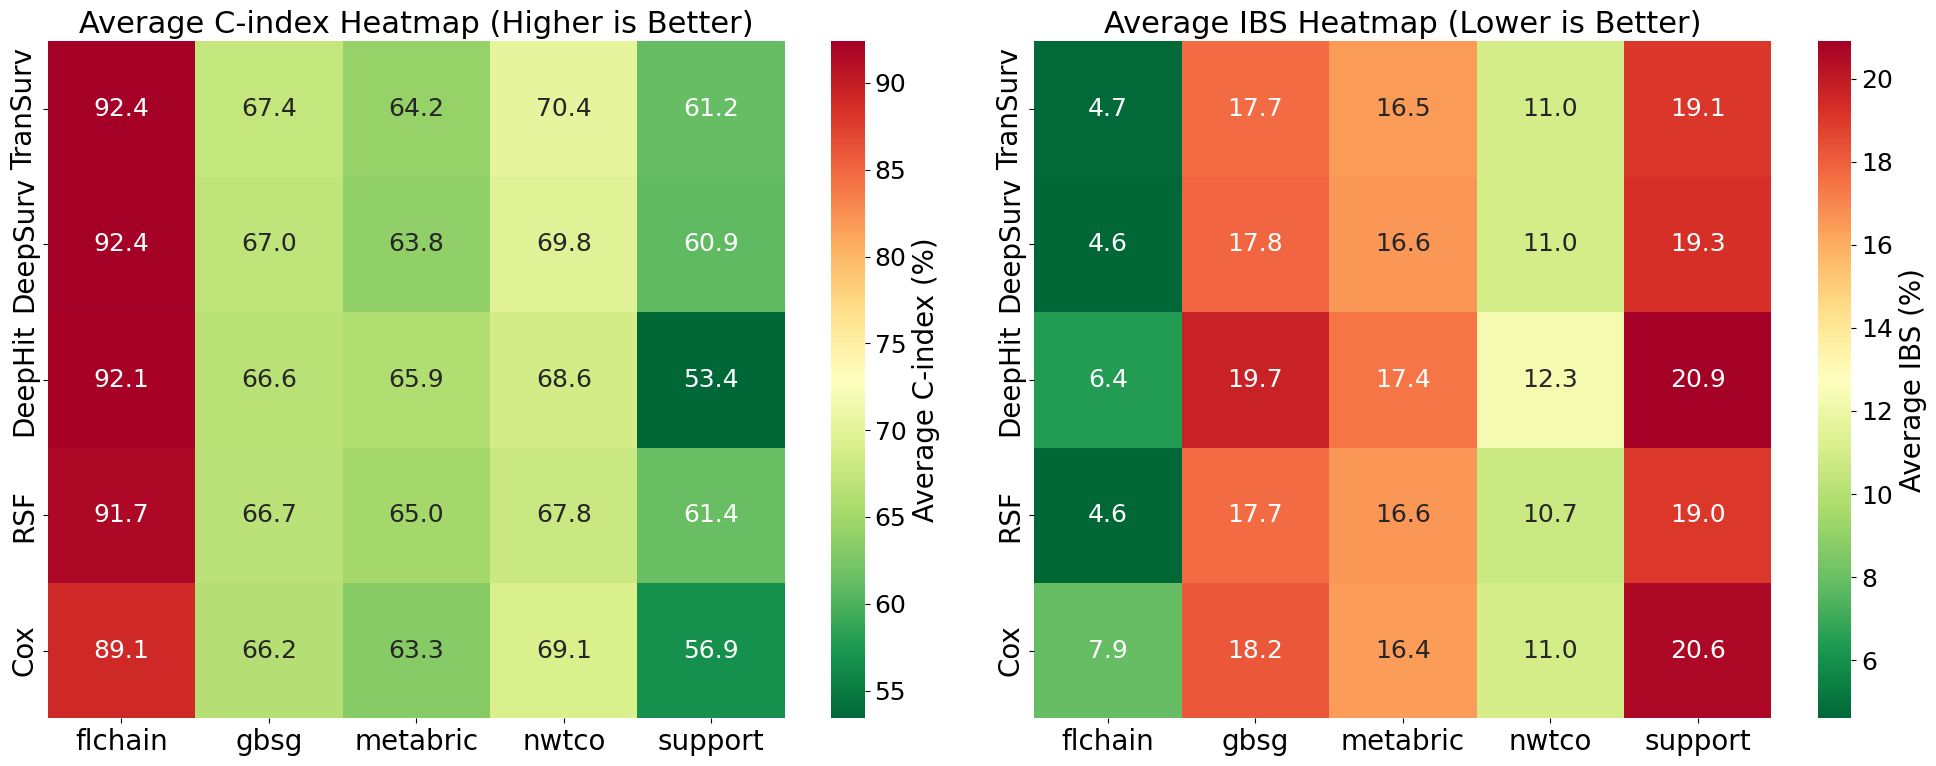

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['font.size'] = 18

# 准备数据
model_names = ['TranSurv', 'DeepSurv', 'DeepHit', 'RSF', 'Cox']
cases = ['flchain', 'gbsg', 'metabric', 'nwtco', 'support']
metrics = ['C-index', 'IBS']

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# C-index 热力图
df_cindex = pd.DataFrame(Mean_cindex, index=model_names, columns=cases)
sns.heatmap(df_cindex, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax1, annot_kws={'size': 18})
ax1.set_title('Average C-index Heatmap (Higher is Better)', fontsize=22)
# 设置坐标轴标签字体大小
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# IBS 热力图
df_ibs = pd.DataFrame(Mean_ibs, index=model_names, columns=cases)
sns.heatmap(df_ibs, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax2)
ax2.set_title('Average IBS Heatmap (Lower is Better)', fontsize=22)
# 设置坐标轴标签字体大小
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


# 调整颜色条标签字体大小
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=18)
cbar1.ax.set_ylabel('Average C-index (%)', fontsize=20)

cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=18)
cbar2.ax.set_ylabel('Average IBS (%)', fontsize=20)


plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/Real_data/Heatmap-2025.09.09.pdf')

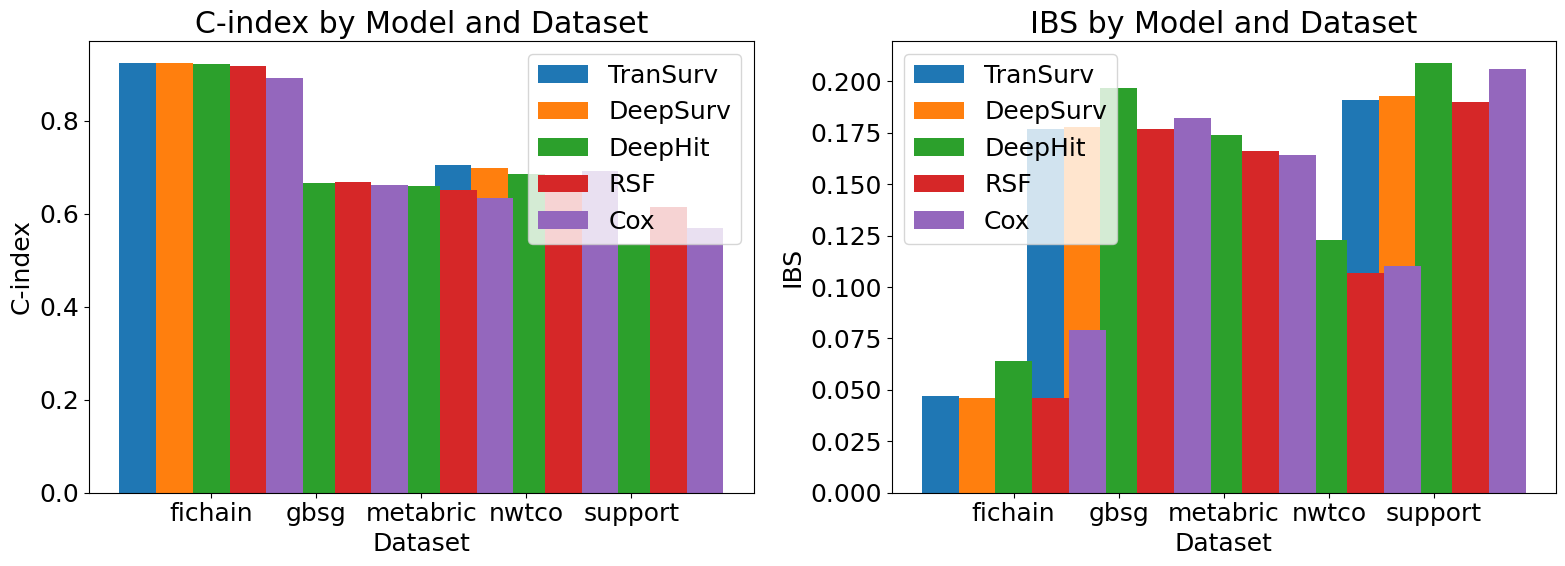

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 创建数据框（根据你的表格）
data = {
    'Model': ['TranSurv', 'DeepSurv', 'DeepHit', 'RSF', 'Cox'] * 5,
    'Dataset': ['fichain']*5 + ['gbsg']*5 + ['metabric']*5 + ['nwtco']*5 + ['support']*5,
    'C-index': [0.924, 0.924, 0.921, 0.917, 0.891, 0.674, 0.670, 0.666, 0.667, 0.662, 0.642, 0.638, 0.659, 0.650, 0.633, 0.704, 0.698, 0.686, 0.678, 0.691, 0.612, 0.609, 0.534, 0.614, 0.569],
    'IBS': [0.047, 0.046, 0.064, 0.046, 0.079, 0.177, 0.178, 0.197, 0.177, 0.182, 0.165, 0.166, 0.174, 0.166, 0.164, 0.110, 0.110, 0.123, 0.107, 0.110, 0.191, 0.193, 0.209, 0.190, 0.206]
}
df = pd.DataFrame(data)

# 设置分组柱状图参数
datasets = df['Dataset'].unique()
models = df['Model'].unique()
n_models = len(models)
n_datasets = len(datasets)
bar_width = 0.35
index = np.arange(n_datasets)

# 创建两个子图：一个用于C-index，一个用于IBS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 绘制C-index的柱状图
for i, model in enumerate(models):
    c_index_values = df[df['Model'] == model]['C-index']
    ax1.bar(index + i * bar_width, c_index_values, bar_width, label=model)

ax1.set_xlabel('Dataset')
ax1.set_ylabel('C-index')
ax1.set_title('C-index by Model and Dataset')
ax1.set_xticks(index + bar_width * (n_models-1)/2)
ax1.set_xticklabels(datasets)
ax1.legend()

# 绘制IBS的柱状图
for i, model in enumerate(models):
    ibs_values = df[df['Model'] == model]['IBS']
    ax2.bar(index + i * bar_width, ibs_values, bar_width, label=model)

ax2.set_xlabel('Dataset')
ax2.set_ylabel('IBS')
ax2.set_title('IBS by Model and Dataset')
ax2.set_xticks(index + bar_width * (n_models-1)/2)
ax2.set_xticklabels(datasets)
ax2.legend()

plt.tight_layout()
plt.show()